<a href="https://colab.research.google.com/github/jgraving/deepposekit/blob/master/examples/step4b_predict_new_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# DeepPoseKit Step 4b - Predict on new data

This is step 4b of the example notebooks for using DeepPoseKit. This notebook shows you how to use your trained model to make predictions on a novel video, detect outliers, merge the outliers with the existing annotation set, and visualize the data output.

**NOTE**: If you run into problems, you can help us improve DeepPoseKit by [opening an issue](https://github.com/jgraving/deepposekit/issues/new) or [submitting a pull request](https://help.github.com/en/articles/creating-a-pull-request-from-a-fork)

**If you're using Colab**: make sure to go to the “Runtime” dropdown menu, select “Change runtime type” and select `GPU` in the "Hardware accelerator" drop-down menu


If you haven't already installed DeepPoseKit you can run the next cell

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

from deepposekit.models import load_model
from deepposekit.io import DataGenerator, VideoReader, VideoWriter
from deepposekit.io.utils import merge_new_images

import tqdm
import time

from scipy.signal import find_peaks

from os.path import expanduser
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

HOME = '.'

Find the saved models

In [2]:
models = sorted(glob.glob(HOME + '/deepposekit-data/datasets/fly/*model*.h5'))
models

['./deepposekit-data/datasets/fly/best_model_densenet.h5',
 './deepposekit-data/datasets/fly/best_model_densenet_old.h5']

# Load the trained model

This loads the trained model into memory for making predictions

In [3]:
model = load_model(HOME + '/deepposekit-data/datasets/fly/best_model_densenet.h5')

Find the available videos

In [4]:
videos = sorted(glob.glob(HOME + '/deepposekit-data/datasets/locust/v*.avi'))
videos

['./deepposekit-data/datasets/locust/video.avi',
 './deepposekit-data/datasets/locust/video2.avi']

# Test the video

Check to make sure `VideoReader` is correctly loading the video frames

In [5]:
reader = VideoReader(HOME + '/deepposekit-data/datasets/locust/outpy.avi', batch_size=10, gray=True)
frames = reader[0]
reader.close()

True

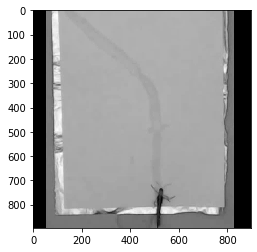

In [6]:
plt.imshow(frames[0,...,0], cmap='gray')
plt.show()

# Makes predictions for the full video

This loads batches of frames and makes predictions.

In [5]:
reader = VideoReader(HOME + '/deepposekit-data/datasets/locust/outpy.avi', batch_size=50, gray=True)
predictions = model.predict(reader, verbose=1)
reader.close()


 4/54 [=>............................] - ETA: 32:47

KeyboardInterrupt: 

# Save the data

Once you have your predictions you can save it however you wish. Here is an example using numpy.save

In [7]:
# np.save(HOME + '/deepposekit-data/datasets/locust/predictions.npy', predictions)

predictions  = np.load(HOME + '/deepposekit-data/datasets/locust/predictions.npy')

This splits the predictions into their x-y coordinates, and confidence scores from each confidence map.

In [8]:
x, y, confidence = np.split(predictions, 3, -1)

Visualize the data output

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/deepposekit/io/DataGenerator.py:81: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.annotated = np.all(h5file["annotated"].value, axis=1)


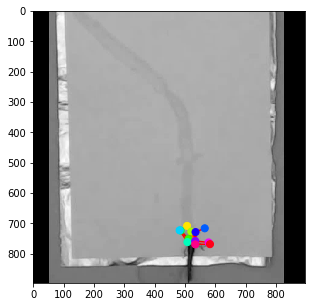

In [9]:
data_generator = DataGenerator(HOME + '/deepposekit-data/datasets/locust/example_annotation_set.h5')

image = frames[0]
keypoints = predictions[0]

plt.figure(figsize=(5,5))
image = image if image.shape[-1] is 3 else image[..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[idx, 0], keypoints[jdx, 0]],
            [keypoints[idx, 1], keypoints[jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[:, 0], keypoints[:, 1],
            c=np.arange(data_generator.keypoints_shape[0]),
            s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

# Detect outlier frames

This is a basic example of how to use confidence scores and temporal derivatives to detect potential outliers and add them to the annotation set.

Plot the confidence scores

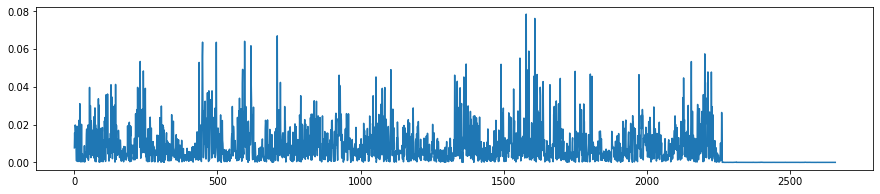

In [10]:
confidence_diff = np.abs(np.diff(confidence.mean(-1).mean(-1)))

plt.figure(figsize=(15, 3))
plt.plot(confidence_diff)
plt.show()

Use `scipy.signal.find_peaks` to detect outliers

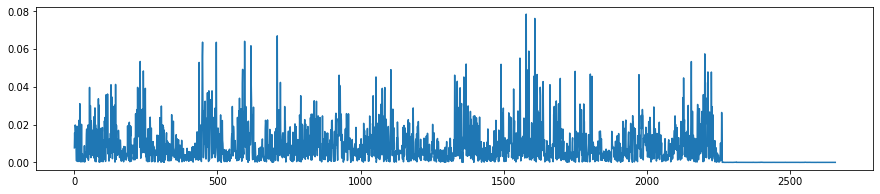

In [11]:
confidence_outlier_peaks = find_peaks(confidence_diff, height=0.1)[0]

plt.figure(figsize=(15, 3))
plt.plot(confidence_diff)
plt.plot(confidence_outlier_peaks, confidence_diff[confidence_outlier_peaks], 'ro')
plt.show()

Calculate the keypoint derivatives and plot them

In [12]:
time_diff = np.diff(predictions[..., :2], axis=0)
time_diff = np.abs(time_diff.reshape(time_diff.shape[0], -1))
time_diff = time_diff.mean(-1)
time_diff.shape

(2660,)

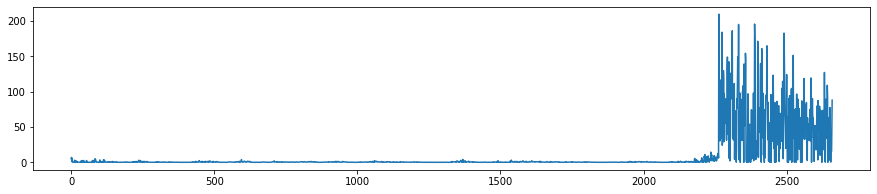

In [13]:
plt.figure(figsize=(15, 3))
plt.plot(time_diff)
plt.show()

Use `scipy.signal.find_peaks` to detect outliers

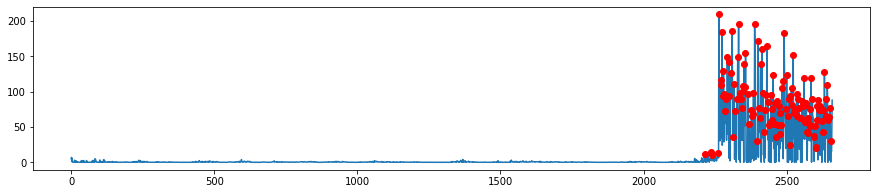

In [14]:
time_diff_outlier_peaks = find_peaks(time_diff, height=10)[0]

plt.figure(figsize=(15, 3))
plt.plot(time_diff)
plt.plot(time_diff_outlier_peaks, time_diff[time_diff_outlier_peaks], 'ro')
plt.show()

Combine the detected outliers into a single index

In [15]:
outlier_index = np.concatenate((confidence_outlier_peaks, time_diff_outlier_peaks))
outlier_index = np.unique(outlier_index) # make sure there are no repeats

Grab the frames and corresponding keypoints for the selected outliers

In [16]:
reader = VideoReader(HOME + '/deepposekit-data/datasets/locust/outpy.avi', batch_size=1, gray=True)

outlier_images = []
outlier_keypoints = []
for idx in outlier_index:
    outlier_images.append(reader[idx])
    outlier_keypoints.append(predictions[idx])

outlier_images = np.concatenate(outlier_images)
outlier_keypoints = np.stack(outlier_keypoints)

reader.close()

outlier_images.shape, outlier_keypoints.shape

((125, 896, 896, 1), (125, 14, 3))

Visualize the outlier frames and keypoint predictions

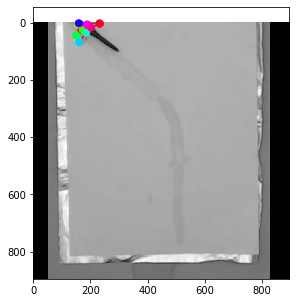

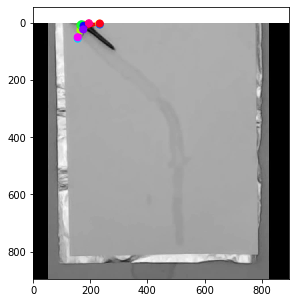

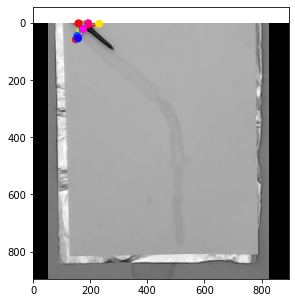

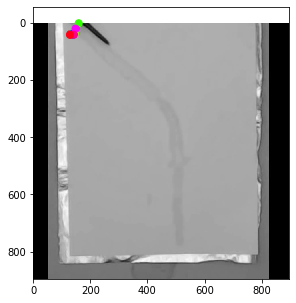

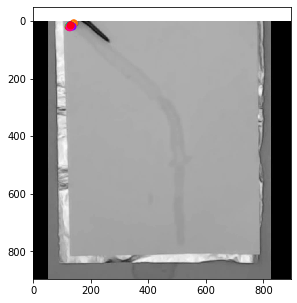

In [34]:
# data_generator = DataGenerator(HOME + '/deepposekit-data/datasets/fly/annotation_data_release.h5')

for idx in range(5):
    image = outlier_images[idx]
    keypoints = outlier_keypoints[idx]

    plt.figure(figsize=(5,5))
    image = image if image.shape[-1] is 3 else image[..., 0]
    cmap = None if image.shape[-1] is 3 else 'gray'
    plt.imshow(image, cmap=cmap, interpolation='none')
    for idx, jdx in enumerate(data_generator.graph):
        if jdx > -1:
            plt.plot(
                [keypoints[idx, 0], keypoints[jdx, 0]],
                [keypoints[idx, 1], keypoints[jdx, 1]],
                'r-'
            )
    plt.scatter(keypoints[:, 0], keypoints[:, 1],
                c=np.arange(data_generator.keypoints_shape[0]),
                s=50, cmap=plt.cm.hsv, zorder=3)

    plt.show()

# Merge outliers with the annotation set
Here we'll use a utility function `merge_new_images` to merge the outliers with our existing annotation set. You can then go annotate them with `deepposekit.annotate.Annotator`. Make sure to use the merged output file!

In [19]:
merge_new_images(
    datapath=HOME + '/deepposekit-data/datasets/fly/annotation_data_release.h5',
    merged_datapath=HOME + '/deepposekit-data/datasets/fly/annotation_data_release_merged.h5',
    images=outlier_images,
    keypoints=outlier_keypoints,
    # overwrite=True # This overwrites the merged dataset if it already exists
)

Load the data with `DataGenerator` and check that the merged data are there

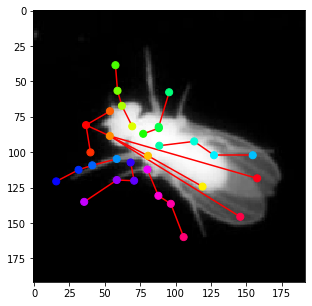

In [21]:
merged_generator = DataGenerator(HOME + '/deepposekit-data/datasets/fly/annotation_data_release_merged.h5', mode="unannotated")

image, keypoints = merged_generator[0]

plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, :, 0], keypoints[0, :, 1], c=np.arange(data_generator.keypoints_shape[0]), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

# Visualize the data as a video

This is an example of how to visualize the predicted posture data on the original video.

In [16]:
# TODO: Turn this into a function
data_generator = DataGenerator(HOME + '/deepposekit-data/datasets/locust/example_annotation_set.h5')

predictions = predictions[...,:2]

resized_shape = (data_generator.image_shape[0], data_generator.image_shape[1])
cmap = plt.cm.hsv(np.linspace(0, 1, data_generator.keypoints_shape[0]))[:, :3][:, ::-1] * 255

writer = VideoWriter(HOME + '/fly_posture.mp4', (data_generator.image_shape[0],data_generator.image_shape[1]), 'MP4V', 30.0)
out = cv2.VideoWriter('/outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 30, (data_generator.image_shape[0],data_generator.image_shape[1]))

reader = VideoReader(HOME + '/deepposekit-data/datasets/locust/outpy.avi', batch_size=1)

for frame, keypoints in tqdm.tqdm(zip(reader, predictions)):
    frame = frame[0]
    frame = frame.copy()
    frame = cv2.resize(frame, resized_shape)
    for idx, node in enumerate(data_generator.graph):
        if node >= 0:
            pt1 = keypoints[idx]
            pt2 = keypoints[node]
            cv2.line(frame, (pt1[0], pt1[1]), (pt2[0], pt2[1]), (0,0,255), 2, cv2.LINE_AA)
    for idx, keypoint in enumerate(keypoints):
        keypoint = keypoint.astype(int)
        cv2.circle(frame, (keypoint[0], keypoint[1]), 5, tuple(cmap[idx]), -1, lineType=cv2.LINE_AA)
        
    writer.write(frame)
    out.write(frame)

writer.close()
out.release()
reader.close()

2661it [00:23, 113.31it/s]


True

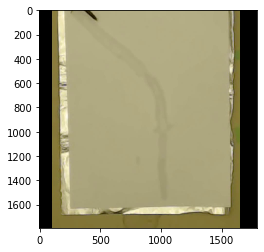

In [36]:
plt.imshow(frame[...,::-1])
plt.show()

In [2]:
VideoReader

In [3]:
DataGenerator?

In [13]:
predictions.shape

(2661, 14, 3)

In [29]:
resized_shape

(1792, 1792)

In [10]:
y.shape

(2661, 14, 1)